In [1]:
# Impoting required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.lines as mlines

# setting default option
pd.set_option("mode.copy_on_write", True)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# loading the Datasets
shipment = pd.read_parquet("../../01_Data/02_Processed/05_Shipment_Final.parquet")

In [3]:
shipment.sample(5)

,BUYER_STATE,BUYER_COUNTY,YEAR,MME,countyfips,Population,MME_Per_Capita
11533,IN,TIPPECANOE,2007,3.096765e+07,18157,166226,186.298458
14725,KY,WAYNE,2006,7.481691e+06,21231,20547,364.12569
39718,WI,BAYFIELD,2015,4.418918e+05,55007,14980,29.498787
26452,NY,CORTLAND,2006,1.211943e+07,36023,49449,245.089454
5875,GA,HENRY,2010,6.931759e+07,13151,205042,338.065344


In [4]:
# Shipement Multiplier
ship_mul = 100000
shipment["MME_mul"] = shipment["MME_Per_Capita"] * ship_mul

# Global Setting for ylabels so that they are consistent across all plots
ylabels = f"MME Shipped per {ship_mul:,} Population"

In [5]:
# Subset the dataset for the analysis
def prepare_data(
    dataset, test_state, control_states, policy_year, start_year, end_year
):
    # Filter states
    state_list = [test_state] + control_states
    sub_dataset = dataset[dataset["BUYER_STATE"].isin(state_list)]

    # Filter years
    sub_dataset = sub_dataset[
        (sub_dataset["YEAR"] >= start_year) & (sub_dataset["YEAR"] <= end_year)
    ]

    # Tagging for pre-post policy implementation and test-control
    sub_dataset["policy_implementation"] = sub_dataset["YEAR"] >= policy_year
    sub_dataset["State_Type"] = sub_dataset["BUYER_STATE"].apply(
        lambda x: "Test" if x == test_state else "Control"
    )

    return sub_dataset

In [6]:
def plot_pre_post_policy_graph(dataset_in, test_state, policy_year, metric_column):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    dataset["YEAR"] = dataset["YEAR"].astype("float64")
    dataset[metric_column] = dataset[metric_column].astype("float64")

    sns.regplot(
        data=dataset[
            (dataset["BUYER_STATE"] == test_state)
            & (dataset["policy_implementation"] == True)
        ],
        x="YEAR",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    sns.regplot(
        data=dataset[
            (dataset["BUYER_STATE"] == test_state)
            & (dataset["policy_implementation"] != True)
        ],
        x="YEAR",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    ax.axvline(policy_year, ls="--", color="orange")

    plt.legend(
        handles=[
            mlines.Line2D([], [], color="blue", label="Pre-Policy"),
            mlines.Line2D([], [], color="red", label="Post-Policy"),
        ],
        loc="lower right",
    )

    plt.title(f"Pre-Post Policy Implementation Trend for Shipment: {test_state}")
    plt.ylabel(ylabels)

    plt.show()

In [7]:
def plot_diff_in_diff_graph(dataset_in, test_state, policy_year, metric_column):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    dataset["YEAR"] = dataset["YEAR"].astype("float64")
    dataset[metric_column] = dataset[metric_column].astype("float64")

    # Plotting for test state - pre-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Test")
            & (dataset["policy_implementation"] != True)
        ],
        x="YEAR",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Plotting for test state - post-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Test")
            & (dataset["policy_implementation"] == True)
        ],
        x="YEAR",
        y=metric_column,
        line_kws={"color": "blue"},
        ax=ax,
        scatter=False,
    )

    # Plotting for control states - pre-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Control")
            & (dataset["policy_implementation"] != True)
        ],
        x="YEAR",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Plotting for control states - post-policy
    sns.regplot(
        data=dataset[
            (dataset["State_Type"] == "Control")
            & (dataset["policy_implementation"] == True)
        ],
        x="YEAR",
        y=metric_column,
        line_kws={"color": "red"},
        ax=ax,
        scatter=False,
    )

    # Adding vertical line for policy year
    ax.axvline(policy_year, ls="--", color="orange")

    # Creating custom legend handles
    blue_line = mlines.Line2D([], [], color="blue", label="Test State")
    red_line = mlines.Line2D([], [], color="red", label="Control States")

    # Adding legends
    plt.legend(handles=[blue_line, red_line], loc="lower right")
    plt.title(f"Difference-in-Difference Analysis for Shipment: {test_state}")
    plt.ylabel(ylabels)

    plt.show()

In [8]:
def plot_all_states(dataset_in, test_state, policy_year, metric_column):
    # Convert YEAR and metric_column to float64
    dataset = dataset_in.copy()  # Copy to avoid changing the original dataframe
    dataset["YEAR"] = dataset["YEAR"].astype("float64")
    dataset[metric_column] = dataset[metric_column].astype("float64")

    plot = sns.lmplot(
        data=dataset,
        x="YEAR",
        y=metric_column,
        hue="policy_implementation",
        legend=False,
        row="BUYER_STATE",
    )

    # Set titles for each subplot
    plot = plot.set_titles("{row_name}")

    plt.legend(
        loc="lower right",
        # bbox_to_anchor=(0.5, -0.15),
        title="Policy Implementation",
        ncol=2,
    )

    ax = plot.axes[0, 0]

    ax.axvline(policy_year, ls="--", color="red")
    ax.set_ylabel(f"MME Shipped per {ship_mul} People")
    plt.show()

# Florida

In [9]:
# Control vars state setup
test_state = "FL"
control_states = ["GA", "NC", "LA"]

# Control vars year setup
policy_year = 2010
start_year = 2007
end_year = 2013

In [10]:
shipment_plot = prepare_data(
    shipment, test_state, control_states, policy_year, start_year, end_year
)
shipment_plot.sample(5)

,BUYER_STATE,BUYER_COUNTY,YEAR,MME,countyfips,Population,MME_Per_Capita,MME_mul,policy_implementation,State_Type
5287,GA,CLAYTON,2013,4.987985e+07,13063,264133,188.84368,18884368.007353,True,Control
23183,NC,PITT,2007,4.276091e+07,37147,157479,271.534035,27153403.497204,False,Control
5617,GA,FAYETTE,2007,2.489912e+07,13113,104989,237.159301,23715930.117288,False,Control
6549,GA,SCREVEN,2012,2.996125e+06,13251,14170,211.441408,21144140.76632,True,Control
22568,NC,DAVIDSON,2010,6.850762e+07,37057,162841,420.702512,42070251.229305,True,Control


/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


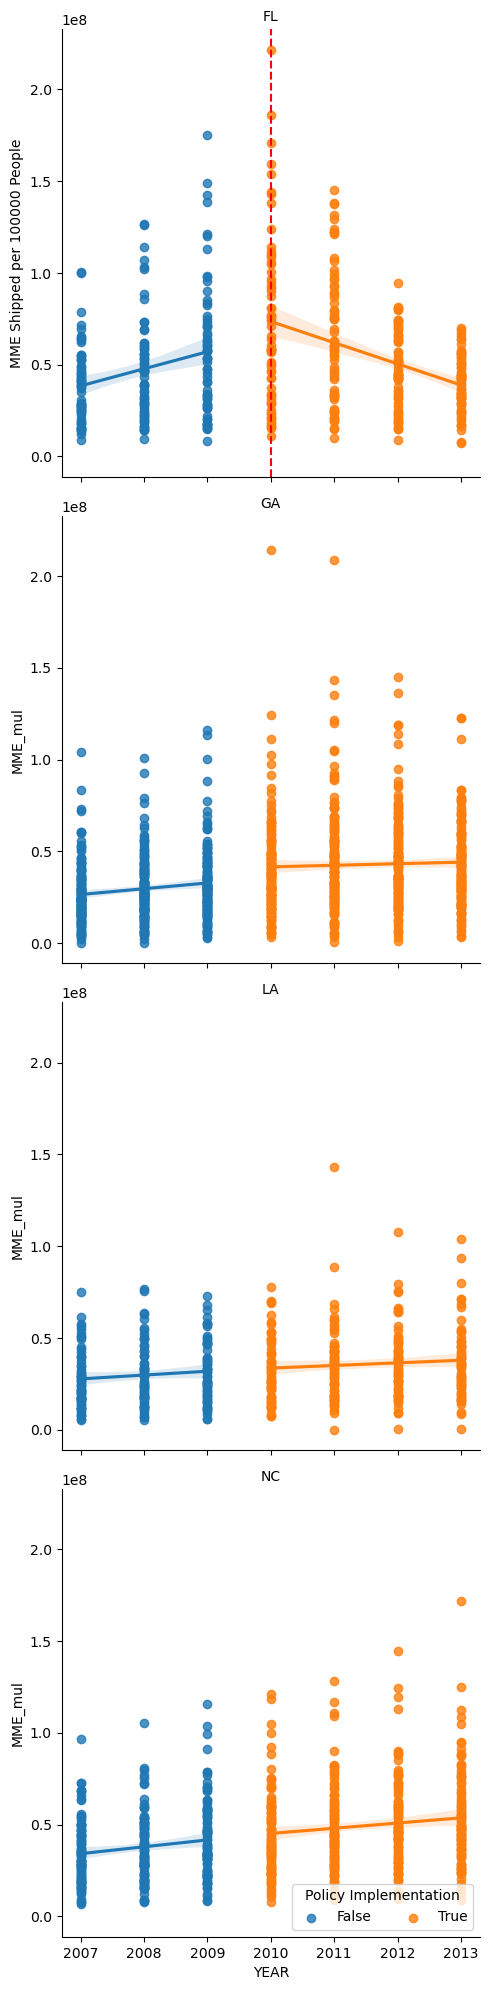

In [11]:
plot_all_states(shipment_plot, test_state, policy_year, "MME_mul")

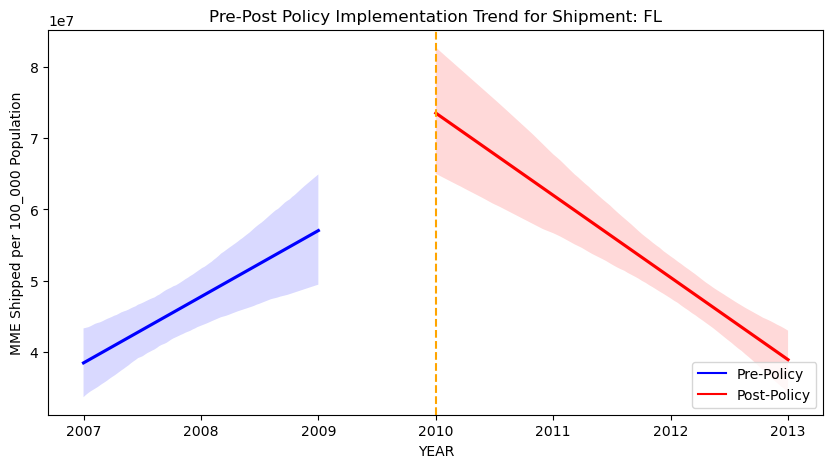

In [12]:
plot_pre_post_policy_graph(shipment_plot, test_state, policy_year, "MME_mul")

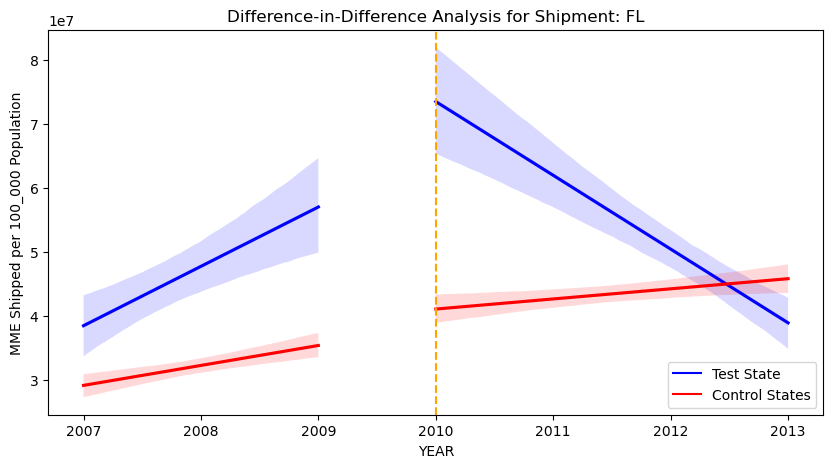

In [13]:
plot_diff_in_diff_graph(shipment_plot, test_state, policy_year, "MME_mul")

# Washington

In [14]:
# Control vars state setup
test_state = "WA"
control_states = ["OR", "WI", "NJ"]

# Control vars year setup
policy_year = 2012
start_year = 2008
end_year = 2015

In [15]:
shipment_plot = prepare_data(
    shipment, test_state, control_states, policy_year, start_year, end_year
)
shipment_plot.sample(5)

,BUYER_STATE,BUYER_COUNTY,YEAR,MME,countyfips,Population,MME_Per_Capita,MME_mul,policy_implementation,State_Type
29561,OR,CROOK,2010,6.986878e+06,41013,20882,334.588566,33458856.551097,False,Control
25633,NJ,SOMERSET,2008,6.855581e+07,34035,318856,215.005546,21500554.588725,False,Control
39703,WI,BARRON,2014,1.258761e+07,55005,45355,277.535162,27753516.227538,True,Control
40260,WI,OUTAGAMIE,2008,3.587811e+07,55087,174388,205.737256,20573725.607188,False,Control
39435,WA,MASON,2012,2.356849e+07,53045,60689,388.348555,38834855.504725,True,Test


/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


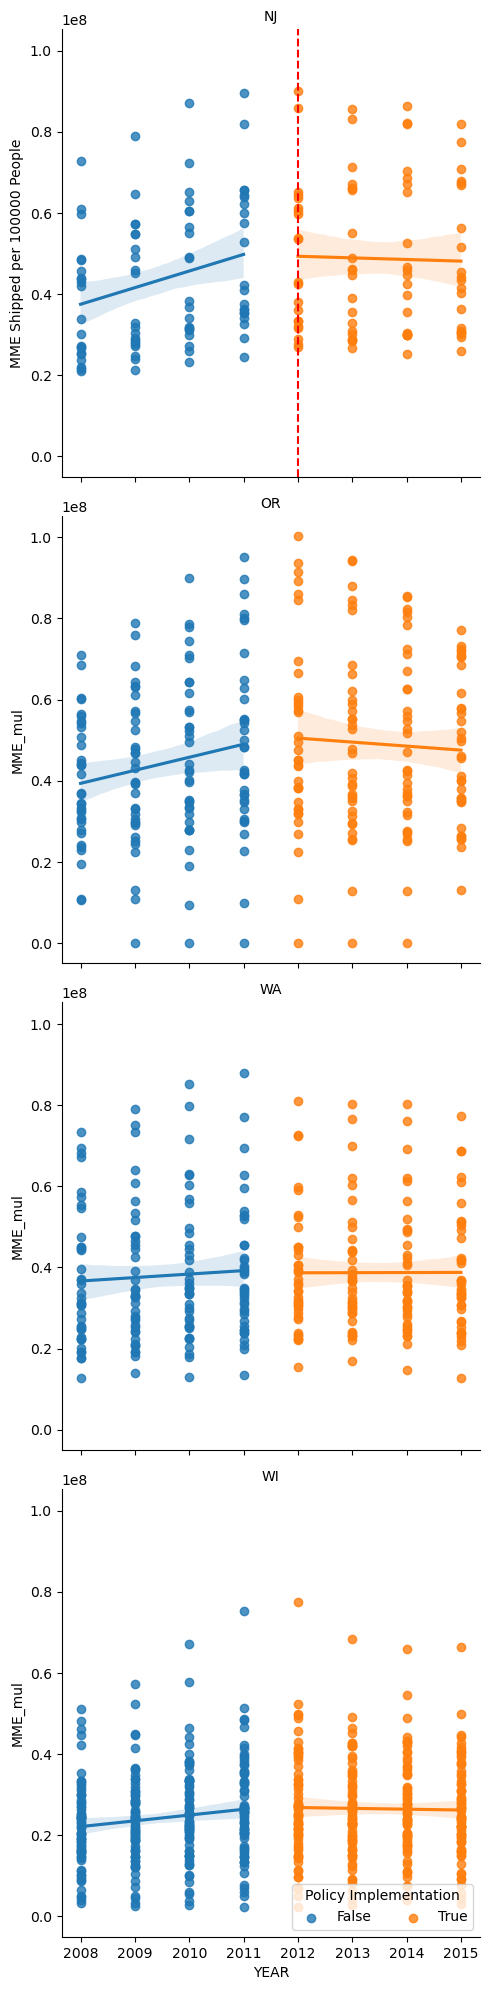

In [16]:
plot_all_states(shipment_plot, test_state, policy_year, "MME_mul")

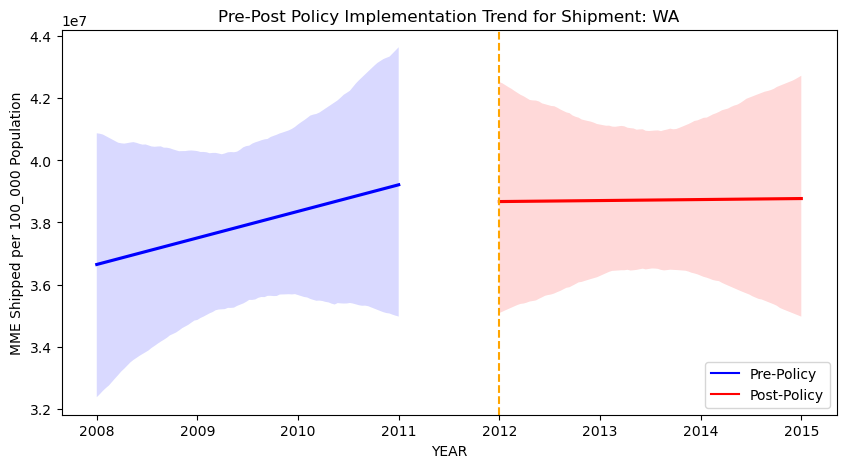

In [17]:
plot_pre_post_policy_graph(shipment_plot, test_state, policy_year, "MME_mul")

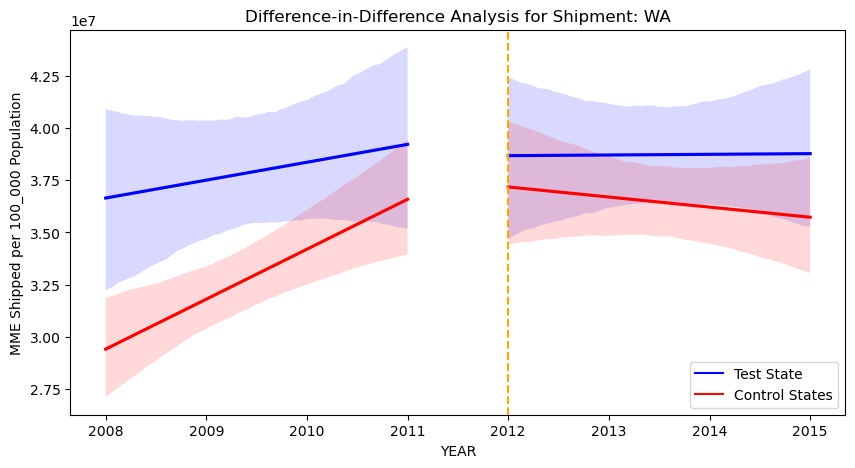

In [18]:
plot_diff_in_diff_graph(shipment_plot, test_state, policy_year, "MME_mul")